In [1066]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stt
import seaborn
seaborn.set(font_scale=1.5,style='ticks')

# Try simpler stuff, use fisher's method to combine p-values

It seems like you lose power by doing this

In [1198]:
n_tests = 8
samp_size = 20
n_hits = 14
val = -2*np.sum([np.log(stt.binom_test(n_hits,samp_size,p=.5))]*n_tests)

In [1199]:
stt.binom_test(n_hits,samp_size,p=.5)

0.11531829833984371

In [1200]:
val

34.56094659688819

In [1201]:
stt.combine_pvalues([stt.binom_test(n_hits,samp_size,p=.5)]*8,method='fisher')

(34.56094659688819, 0.004561789552228282)

In [1202]:
stt.binom_test(n_tests*n_hits,n_tests*samp_size,p=.5)

4.5091152205445995e-07

In [ ]:
stt.binom_test

# Ok there is an analytic solution the Poisson-binomial distribution

https://www.sciencedirect.com/science/article/pii/S0167947312003568

In [1304]:
import collections
import numpy as np


class PoiBin(object):
    """Poisson Binomial distribution for random variables.
    This class implements the Poisson Binomial distribution for Bernoulli
    trials with different success probabilities. The distribution describes
    thus a random variable that is the sum of independent and not identically
    distributed single Bernoulli random variables.
    The class offers methods for calculating the probability mass function, the
    cumulative distribution function, and p-values for right-sided testing.
    """

    def __init__(self, probabilities):
        """Initialize the class and calculate the ``pmf`` and ``cdf``.
        :param probabilities: sequence of success probabilities :math:`p_i \\in
            [0, 1] \\forall i \\in [0, N]` for :math:`N` independent but not
            identically distributed Bernoulli random variables
        :type probabilities: numpy.array
        """
        self.success_probabilities = np.array(probabilities)
        self.number_trials = self.success_probabilities.size
        self.check_input_prob()
        self.omega = 2 * np.pi / (self.number_trials + 1)
        self.pmf_list = self.get_pmf_xi()
        self.cdf_list = self.get_cdf(self.pmf_list)

# ------------------------------------------------------------------------------
# Methods for the Poisson Binomial Distribution
# ------------------------------------------------------------------------------

    def pmf(self, number_successes):
        """Calculate the probability mass function ``pmf`` for the input values.
        The ``pmf`` is defined as
        .. math::
            pmf(k) = Pr(X = k), k = 0, 1, ..., n.
        :param number_successes: number of successful trials for which the
            probability mass function is calculated
        :type number_successes: int or list of integers
        """
        self.check_rv_input(number_successes)
        return self.pmf_list[number_successes]

    def cdf(self, number_successes):
        """Calculate the cumulative distribution function for the input values.
        The cumulative distribution function ``cdf`` for a number ``k`` of
        successes is defined as
        .. math::
            cdf(k) = Pr(X \\leq k), k = 0, 1, ..., n.
        :param number_successes: number of successful trials for which the
            cumulative distribution function is calculated
        :type number_successes: int or list of integers
        """
        self.check_rv_input(number_successes)
        return self.cdf_list[number_successes]

    def pval(self, number_successes):
        """Return the p-values corresponding to the input numbers of successes.
        The p-values for right-sided testing are defined as
        .. math::
            pval(k) = Pr(X \\geq k ),  k = 0, 1, ..., n.
        .. note::
            Since :math:`cdf(k) = Pr(X <= k)`, the function returns
            .. math::
                1 - cdf(X < k) & = 1 - cdf(X <= k - 1)
                               & = 1 - cdf(X <= k) + pmf(X = k),
                               k = 0, 1, .., n.
        :param number_successes: number of successful trials for which the
            p-value is calculated
        :type number_successes: int, numpy.array, or list of integers
        """
        self.check_rv_input(number_successes)
        i = 0
        try:
            isinstance(number_successes, collections.Iterable)
            pvalues = np.array(number_successes, dtype='float')
            # if input is iterable (list, numpy.array):
            for k in number_successes:
                pvalues[i] = 1. - self.cdf(k) + self.pmf(k)
                i += 1
            return pvalues
        except TypeError:
            # if input is an integer:
            if number_successes == 0:
                return 1
            else:
                return 1 - self.cdf(number_successes - 1)

# ------------------------------------------------------------------------------
# Methods to obtain pmf and cdf
# ------------------------------------------------------------------------------

    def get_cdf(self, event_probabilities):
        """Return the values of the cumulative density function.
        Return a list which contains all the values of the cumulative
        density function for :math:`i = 0, 1, ..., n`.
        :param event_probabilities: array of single event probabilities
        :type event_probabilities: numpy.array
        """
        cdf = np.empty(self.number_trials + 1)
        cdf[0] = event_probabilities[0]
        for i in range(1, self.number_trials + 1):
            cdf[i] = cdf[i - 1] + event_probabilities[i]
        return cdf

    def get_pmf_xi(self):
        """Return the values of the variable ``xi``.
        The components ``xi`` make up the probability mass function, i.e.
        :math:`\\xi(k) = pmf(k) = Pr(X = k)`.
        """
        chi = np.empty(self.number_trials + 1, dtype=complex)
        chi[0] = 1
        half_number_trials = int(
            self.number_trials / 2 + self.number_trials % 2)
        # set first half of chis:
        chi[1:half_number_trials + 1] = self.get_chi(
            np.arange(1, half_number_trials + 1))
        # set second half of chis:
        chi[half_number_trials + 1:self.number_trials + 1] = np.conjugate(
            chi[1:self.number_trials - half_number_trials + 1] [::-1])
        chi /= self.number_trials + 1
        xi = np.fft.fft(chi)
        if self.check_xi_are_real(xi):
            xi = xi.real
        else:
            raise TypeError("pmf / xi values have to be real.")
        xi += np.finfo(type(xi[0])).eps
        return xi

    def get_chi(self, idx_array):
        """Return the values of ``chi`` for the specified indices.
        :param idx_array: array of indices for which the ``chi`` values should
            be calculated
        :type idx_array: numpy.array
        """
        # get_z:
        exp_value = np.exp(self.omega * idx_array * 1j)
        xy = 1 - self.success_probabilities + \
            self.success_probabilities * exp_value[:, np.newaxis]
        # sum over the principal values of the arguments of z:
        argz_sum = np.arctan2(xy.imag, xy.real).sum(axis=1)
        # get d value:
        exparg = np.log(np.abs(xy)).sum(axis=1)
        d_value = np.exp(exparg)
        # get chi values:
        chi = d_value * np.exp(argz_sum * 1j)
        return chi

# ------------------------------------------------------------------------------
# Auxiliary functions
# ------------------------------------------------------------------------------

    def check_rv_input(self, number_successes):
        """Assert that the input values ``number_successes`` are OK.
        The input values ``number_successes`` for the random variable have to be
        integers, greater or equal to 0, and smaller or equal to the total
        number of trials ``self.number_trials``.
        :param number_successes: number of successful trials
        :type number_successes: int or list of integers """
        try:
            for k in number_successes:
                assert (type(k) == int or type(k) == np.int64), \
                        "Values in input list must be integers"
                assert k >= 0, 'Values in input list cannot be negative.'
                assert k <= self.number_trials, \
                    'Values in input list must be smaller or equal to the ' \
                    'number of input probabilities "n"'
        except TypeError:
            assert (type(number_successes) == int or \
                type(number_successes) == np.int64), \
                'Input value must be an integer.'
            assert number_successes >= 0, "Input value cannot be negative."
            assert number_successes <= self.number_trials, \
                'Input value cannot be greater than ' + str(self.number_trials)
        return True

    @staticmethod
    def check_xi_are_real(xi_values):
        """Check whether all the ``xi``s have imaginary part equal to 0.
        The probabilities :math:`\\xi(k) = pmf(k) = Pr(X = k)` have to be
        positive and must have imaginary part equal to zero.
        :param xi_values: single event probabilities
        :type xi_values: complex
        """
        return np.all(xi_values.imag <= np.finfo(float).eps)

    def check_input_prob(self):
        """Check that all the input probabilities are in the interval [0, 1]."""
        if self.success_probabilities.shape != (self.number_trials,):
            raise ValueError(
                "Input must be an one-dimensional array or a list.")
        if not np.all(self.success_probabilities >= 0):
            raise ValueError("Input probabilities have to be non negative.")
        if not np.all(self.success_probabilities <= 1):
            raise ValueError("Input probabilities have to be smaller than 1.")

################################################################################
# Main
################################################################################

if __name__ == "__main__":
    pass

In [1353]:
import numpy as np
from math import atan2,sqrt,log,cos,sin,exp,pi
from scipy.fft import fft

class PoissonBinomial:
    """
    The poisson binomial distribution is essentially a binomial
    distribution where the probability of success on each trial
    is not necessarily identically distributed. This implementation
    and results are checked against https://github.com/tsakim/poibin/blob/master/poibin.py
    If all ps in prob_array are equal, this distribution reverts to the
    binomial distribution. This resultant p-values have also been checked 
    against the scipy implementation
    
    from https://pypi.org/project/poisson-binomial/#files
    """
    def __init__(self,prob_array):
        self.p = np.array(prob_array)
        self.pmf = self.get_poisson_binomial()
        self.cdf = np.cumsum(self.pmf)
        
    def x_or_less(self,x):
        return self.cdf[x]
    def x_or_more(self,x):
        return 1-self.cdf[x]+self.pmf[x]

    def get_poisson_binomial(self):

        """This version of the poisson_binomial is implemented 
        from the fast fourier transform method described in 
        'On computing the distribution function for the 
        Poisson binomial distribution'by Yili Hong 2013."""

        real = np.vectorize(lambda x: x.real)

        def x(w,l):
            v_atan2 = np.vectorize(atan2)
            v_sqrt = np.vectorize(sqrt)
            v_log = np.vectorize(log)

            if l==0:
                return complex(1,0)
            else:

                wl = w*l
                real = 1+self.p*(cos(wl)-1)
                imag = self.p*sin(wl)
                mod = v_sqrt(imag**2+real**2)
                arg = v_atan2(imag,real)
                d = exp((v_log(mod)).sum())
                arg_sum = arg.sum()
                a = d*cos(arg_sum)
                b = d*sin(arg_sum)
                return complex(a,b)

        n = self.p.size 
        w = 2*pi/(1+n)

        xs = [x(w,i) for i in range((n+1)//2+1)]
        for i in range((n+1)//2+1,n+1):
            c = xs[n+1-i]
            xs.append(c.conjugate())

        return real(fft(xs))/(n+1)

In [1402]:
n_draws = 50
coin_ps = np.clip(np.random.random(size=n_draws),0,.8)
coin_ps = np.clip(np.random.random(size=n_draws),0,.8)
coin_ps2 = np.clip(coin_ps + 0.2,0,1)
my_draw = np.array([np.random.binomial(1,p=p_) for p_ in coin_ps2])

n_samps = 100000
draws = np.array([np.random.binomial(1,p=p_,size=n_samps) for p_ in coin_ps])


In [1403]:
pbd = PoissonBinomial(coin_ps)

In [1404]:
all_ps = [pbd.x_or_more(np.sum(draws[:,i])) for i in range(n_samps-1)]

In [1405]:
#binom_check = [stt.binom_test(np.sum(draws[:,i]),50,p=.5,alternative='greater') for i in range(n_samps-1)]

In [1406]:
np.allclose(binom_check,all_ps)

False

In [1407]:
np.percentile(all_ps,5)

0.058610340006820416

In [1410]:
1- pbd.x_or_more(np.sum(my_draw))

0.9999759827398287

In [1411]:
pbd.x_or_more(np.sum(my_draw))

2.4017260171307787e-05

In [1339]:
PoissonBinomial([.])

0.62

In [1340]:
np.mean(draws)

0.42682726

In [1341]:
pbd.x_or_more(np.sum(draws[:,0]))

0.8277964998740646

In [1342]:
pdb2 = PoiBin(coin_ps)

In [1343]:
all_ps2 = [pdb2.pval(np.sum(draws[:,i])) for i in range(n_samps)]

In [1345]:
all_ps[:5]

[0.8277964998740646,
 0.4789403750920296,
 0.35037801671041635,
 0.8998036154586944,
 0.1475835804052961]

In [ ]:
PoiBin

In [1349]:
np.allclose(all_ps,all_ps2[:-1])

True

In [1344]:
np.percentile(all_ps2,5)

0.08403893523868589

# Run simulations etc 

In [1094]:
bernoulli_pmf = lambda x,p: p**x * (1-p)**(1-x)
log_bernoulli_pmf = lambda  x,p: x*np.log(p) + (1-x)*np.log(1-p)

In [1095]:
coin_ps = np.clip(np.random.random(size=40),0,.8)
coin_ps2 = np.clip(coin_ps + 0.3,0,1)
my_draw = np.array([np.random.binomial(1,p=p_) for p_ in coin_ps2])

n_samps = 10000
draws = np.array([np.random.binomial(1,p=p_,size=n_samps) for p_ in coin_ps])
bigstore = log_bernoulli_pmf(draws,coin_ps[:,None])
store = np.sum(bigstore,axis=0)

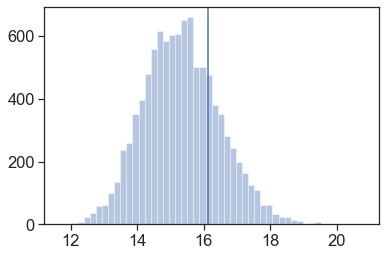

In [1096]:
seaborn.distplot(np.sum(np.abs(draws - coin_ps[:,None]),axis=0),kde=0)
plt.axvline(x=np.sum(np.abs(my_draw-coin_ps)))

In [1097]:
for i,j,k in zip(*[np.mean(draws,axis=1),draw,coin_ps2]):
    print(i,j,k)

0.0289 1 0.33060797165797823
0.2348 1 0.5399549653585483
0.7953 1 1.0
0.6642 1 0.9640430352769693
0.7851 0 1.0
0.7984 0 1.0
0.7962 1 1.0
0.6795 1 0.9793117106780682
0.5661 1 0.8726419062367408
0.7878 1 1.0
0.7929 0 1.0
0.3361 1 0.6303648529594958
0.2161 1 0.5178846871008163
0.5181 0 0.8199416006460949
0.144 0 0.44184522597524883
0.1741 0 0.4731984245961178
0.4642 0 0.7650793161003975
0.3207 0 0.6309077263823881
0.8008 1 1.0
0.6606 0 0.954414670325533


In [1098]:
draw

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0])

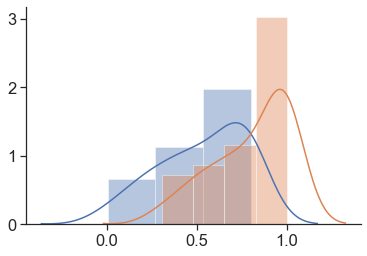

In [1099]:
seaborn.distplot(coin_ps)
seaborn.distplot(coin_ps2)
seaborn.despine()

In [1100]:
stt.binom_test(np.sum(draw),len(draw),np.mean(draws))

1.0

In [1101]:
allP = np.sum(log_bernoulli_pmf(my_draw,p=coin_ps))


In [1102]:
stt.binom_test(np.sum(my_draw),len(my_draw),np.mean(draws))

0.006464027883250764

In [1103]:
coin_ps

array([0.03060797, 0.23995497, 0.8       , 0.66404304, 0.79379337,
       0.8       , 0.8       , 0.67931171, 0.57264191, 0.78145742,
       0.8       , 0.33036485, 0.21788469, 0.5199416 , 0.14184523,
       0.17319842, 0.46507932, 0.33090773, 0.8       , 0.65441467,
       0.0062841 , 0.8       , 0.31580622, 0.50148737, 0.8       ,
       0.41945671, 0.17762559, 0.40345473, 0.64831137, 0.70395158,
       0.50558752, 0.64751784, 0.8       , 0.60512849, 0.46535712,
       0.31563406, 0.62857587, 0.8       , 0.75474783, 0.43923625])

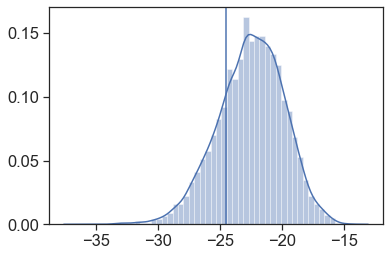

In [1104]:
seaborn.distplot(store)
plt.axvline(x=allP)

In [1105]:
stt.percentileofscore(store,allP)

21.93

In [1106]:
np.mean(draws)

0.532005

In [1107]:
np.mean(my_draw)

0.75

# Tests

In [718]:

n_samps = 100000
store = []
draws = np.array([np.random.binomial(1,p=p_,size=n_samps) for p_ in coin_ps])

for i in range(n_samps):
    #draw = [np.random.binomial(1,p=p_) for p_ in coin_ps]
    allP_ = np.sum(log_bern_pmf(draws[:,i],coin_ps))
    store.append(allP_)
    
#%%timeit
store2 = log_bern_pmf(draws,coin_ps[:,None]).sum(axis=0)

np.allclose(store,store2)

True

In [312]:
a,b = np.random.random(size=100)>.5,np.random.random(size=100)
np.allclose(np.log(np.product(bernoulli_pmf(a,b))),np.sum(log_bernoulli_pmf(a,b)))

True

-90.99256538652124